# Reading 15 million reviews 

*what is the best way to read 15 million reviews?* 

In [2]:
import gzip 
import json
import os

import pandas as pd

In [3]:
DIR = "./data"

In [4]:
def format_data(file_name, head=100):
    # 15739967
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            
            # only get review_text and review_stars
            data.append([d['review_text'], d['n_votes'], d['rating']])


            # break if reaches the headth line
            if (head is not None) and (count > head):
                break
    return data

In [5]:
# reviews = pd.DataFrame(format_data(os.path.join(
#     DIR, "goodreads_reviews_dedup.json.gz"))
# )

reviews = pd.read_csv("data/liwc_sample.csv")

In [6]:
reviews

,review_text,n_votes,rating,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,...,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji
0,Mind blowingly cool. Best science fiction I've...,16,5,1,174,32.86,27.51,39.59,65.53,19.33,...,0.0,0.0,13.79,5.17,2.30,0.00,0.00,2.87,3.45,0
1,This is a special book. It started slow for ab...,28,5,1,358,63.49,35.27,64.13,45.44,17.90,...,0.0,0.0,14.80,5.31,3.07,1.12,0.00,0.84,4.47,0
2,I haven't read a fun mystery book in a while a...,6,3,1,86,22.00,6.98,91.21,95.15,12.29,...,0.0,0.0,16.28,6.98,2.33,0.00,1.16,4.65,1.16,0
3,"Fun, fast paced, and disturbing tale of murder...",22,4,1,179,23.12,10.38,83.40,27.64,19.89,...,0.0,0.0,15.64,5.03,2.79,0.00,0.00,1.12,6.70,0
4,A fun book that gives you a sense of living in...,8,4,1,79,92.60,32.92,56.26,99.00,15.80,...,0.0,0.0,7.59,6.33,0.00,0.00,0.00,0.00,1.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Tessa Bailey is known for writing the dirtiest...,0,5,1,255,39.70,58.73,4.94,75.21,12.75,...,0.0,0.0,18.04,5.88,5.49,1.18,0.78,3.14,1.57,0
996,4.5 stars!! Sweet Filthy Boy is the first book...,0,4,1,273,88.48,19.55,61.86,85.37,17.06,...,0.0,0.0,14.29,5.13,4.03,0.00,2.20,1.47,1.47,0
997,This is an unexpectedly funny book with lots o...,1,4,1,179,41.04,69.35,29.07,99.00,19.89,...,0.0,0.0,12.29,3.91,3.35,0.00,1.12,2.79,1.12,0
998,I liked this installment better than the first...,1,4,1,93,32.41,14.43,66.26,84.42,13.29,...,0.0,0.0,17.20,4.30,1.08,0.00,6.45,4.30,1.08,0


In [7]:
reviews.to_csv(os.path.join(DIR, "sample.csv"), index=False)

# EDA

In [8]:
import nltk

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import string

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [9]:
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

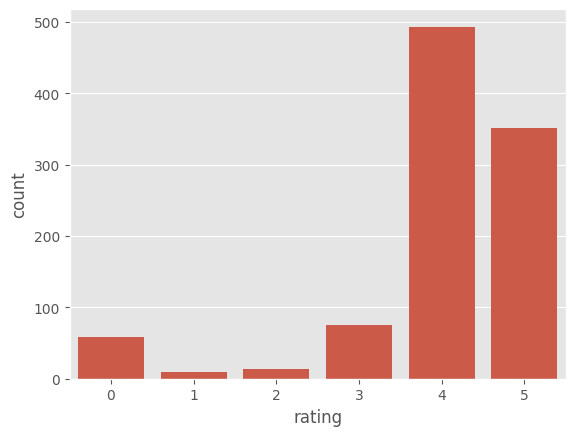

In [10]:
ax = sns.countplot(data=reviews, x='rating')

In [11]:
example = reviews.iloc[55]['review_text']
print(example)

A wonderful, beautifully written, poignant, subtle, and brilliant novel. 
 This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end. It is ultimately a story of regret. It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back. One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework. 
 But what I really loved about the novel is how slow and forcefully it builds. I don't think I've read a book that does that so well since Pride and Prejudice. In the beginning you think it's just a butler going on a motoring trip. And at the end, your heart is breaking. 
 Dignity is a big theme in the novel. Stevens attempts to define dignity several times throughout the novel - his definition generally has to do with self-respect and keeping on

In [12]:
sentences = sent_tokenize(example)
sentences

['A wonderful, beautifully written, poignant, subtle, and brilliant novel.',
 'This is the story of an English butler of one the great houses, whose self value comes from his duty and his dignity, and who questions his values and his life in the end.',
 'It is ultimately a story of regret.',
 "It is a story that makes you want to live your life and dedicate yourself to things that you won't regret when you look back.",
 "One of the best ways of thinking about regret I've ever come across is from Jeff Bezos in his nerdily titled Regret Minimization Framework.",
 'But what I really loved about the novel is how slow and forcefully it builds.',
 "I don't think I've read a book that does that so well since Pride and Prejudice.",
 "In the beginning you think it's just a butler going on a motoring trip.",
 'And at the end, your heart is breaking.',
 'Dignity is a big theme in the novel.',
 'Stevens attempts to define dignity several times throughout the novel - his definition generally has to

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
def extract_sentiment_terms(sentence):
    # Tokenize words and tag part of speech
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    sentiment_terms = set()

    for word, tag in tagged_words:
        if word.lower() not in stop_words and word not in string.punctuation:
            if tag.startswith('JJ') or tag.startswith('RB'):
                if word.lower() in opinion_lexicon.positive() or word.lower() in opinion_lexicon.negative():
                    sentiment_terms.add(word)

    return sentiment_terms


In [15]:
sentiment_terms = set()
for sentence in sentences:
    sentiment_terms.update(extract_sentiment_terms(sentence))

In [16]:
sentiment_terms = list(sentiment_terms)
sentiment_terms[0:5]

['Good', 'self-respect', 'well', 'better', 'poignant']

In [17]:
from gensim.models import Word2Vec
import networkx as nx

In [18]:
# get all sentiement terms from all reviews
sentiment_terms = set()
for review in reviews['review_text']:
    sentences = sent_tokenize(review)
    for sentence in sentences:
        sentiment_terms.update(extract_sentiment_terms(sentence))

KeyboardInterrupt: 

In [19]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

In [20]:
def learn_word_embeddings(processed_corpus):
    # Train a Word2Vec model on the processed corpus
    model = Word2Vec(sentences=processed_corpus,
                     vector_size=100, window=5, min_count=1, workers=4)
    return model       

In [21]:
model = learn_word_embeddings([word_tokenize(word) for word in sentiment_terms])

token = 'amazing'

if token in model.wv:
    print(f"{token}: {model.wv.most_similar(token)}")
else:
    synonyms = get_synonyms(token)

    for synonym in synonyms:
        if synonym in model.wv:
            print(f"{synonym}: {model.wv.most_similar(synonym)}")

amazing: [('sufficient', 0.2987786829471588), ('pretty', 0.2982717454433441), ('creative', 0.2408866584300995), ('ambitious', 0.24001356959342957), ('Well', 0.23229120671749115), ('bullshit', 0.2235596776008606), ('available', 0.2103513479232788), ('valuable', 0.20808722078800201), ('corrupt', 0.19869357347488403), ('hilarious', 0.19359393417835236)]


# Training Dataset

In [22]:
essays = pd.read_csv('data/essays.csv')

## Preprocessing

In [23]:
essays = essays.rename(columns={
    'TEXT': 'text',
    'cEXT': 'extroversion',
    'cNEU': 'neuroticism',
    'cAGR': 'agreeableness',
    'cCON': 'conscientiousness',
    'cOPN': 'openness'
})

# subset the data text + big five

essays = essays[['text', 'extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']]

# convert n and y to 0 and 1
essays = essays.replace({'n': 0, 'y': 1})

/var/folders/lg/qth2myc91gj4tfy56qzfn3b40000gn/T/ipykernel_97856/1694335583.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  essays = essays.replace({'n': 0, 'y': 1})


In [24]:
essays

,text,extroversion,neuroticism,agreeableness,conscientiousness,openness
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,I can't believe it! It's really happening! M...,1,0,1,1,0
4,"Well, here I go with the good old stream of co...",1,0,1,0,1
...,...,...,...,...,...,...
2462,I'm home. wanted to go to bed but remembe...,0,1,0,1,0
2463,Stream of consiousnesssskdj. How do you s...,1,1,0,0,1
2464,"It is Wednesday, December 8th and a lot has be...",0,0,1,0,0
2465,"Man this week has been hellish. Anyways, now i...",0,1,0,0,1


In [25]:
essays.to_pickle('data/essays.pkl')

# Training the model

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from preprocessing import preprocess_text
from tqdm import tqdm
import pandas as pd
import joblib

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessedoka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jessedoka/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
tqdm.pandas()

def load_data(file_path):
    # Load Pickled data
    df = pd.read_pickle(file_path)

    df['preprocessed_text'] = df['text'].progress_apply(lambda x: ' '.join(map(str, preprocess_text(x)))) # type: ignore

    return df

In [28]:
def evaluate_model(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [29]:
def train_model(df, target_columns, model, model_path):

    X = df['preprocessed_text']
    y = df[target_columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy, precision, recall, f1 = evaluate_model(y_test, y_pred)

    if model_path is not None:
        joblib.dump(model, model_path)

    return [model, accuracy, precision, recall, f1]

In [30]:
df = load_data('data/essays.pkl')

  0%|          | 0/2467 [00:00<?, ?it/s]

  1%|          | 21/2467 [00:07<13:57,  2.92it/s]


KeyboardInterrupt: 

In [31]:
df = pd.read_pickle('data/essays_preprocessed.pkl')

In [32]:
df

,text,extroversion,neuroticism,agreeableness,conscientiousness,openness,preprocessed_text
0,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1,"['well', ',', 'right', 'woke', 'mid-day', 'nap..."
1,"Well, here we go with the stream of consciousn...",0,0,1,0,0,"['well', ',', 'go', 'stream', 'consciousness',..."
2,An open keyboard and buttons to push. The thin...,0,1,0,1,1,"['open', 'keyboard', 'buttons', 'push', '.', '..."
3,I can't believe it! It's really happening! M...,1,0,1,1,0,"['ca', ""n't"", 'believe', '!', ""'s"", 'really', ..."
4,"Well, here I go with the good old stream of co...",1,0,1,0,1,"['well', ',', 'go', 'good', 'old', 'stream', '..."
...,...,...,...,...,...,...,...
2462,I'm home. wanted to go to bed but remembe...,0,1,0,1,0,"[""'m"", 'home', '.', 'wanted', 'go', 'bed', 're..."
2463,Stream of consiousnesssskdj. How do you s...,1,1,0,0,1,"['stream', 'consiousnesssskdj', '.', 'spell', ..."
2464,"It is Wednesday, December 8th and a lot has be...",0,0,1,0,0,"['wednesday', ',', 'december', '8th', 'lot', '..."
2465,"Man this week has been hellish. Anyways, now i...",0,1,0,0,1,"['man', 'week', 'hellish', '.', 'anyways', ','..."


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
traits = ['extroversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']

results = {}

# Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])

In [37]:
results["logistic_regression"] = train_model(df, traits, model, 'models/big_five_model.pkl')

In [39]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

results["logistic_regression improved"] = train_model(df, traits, grid_search, None)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


# Multi Model Approach

In [40]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [41]:
results["LR Multi-Model"] = {}
for t in traits:
    print(f'Training model for {t}')
    results["LR Multi-Model"][t] = train_model(df, t, model, None)

Training model for extroversion
Training model for neuroticism
Training model for agreeableness
Training model for conscientiousness
Training model for openness


In [43]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)
results["LR Multi-Model Classification Improved"] = {}

for t in traits:
    print(f'Training model for {t}')
    results["LR Multi-Model Classification Improved"][t] = train_model(df, t, grid_search, None)
    

Training model for extroversion
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for neuroticism
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for agreeableness
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for conscientiousness
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for openness
Fitting 5 folds for each of 27 candidates, totalling 135 fits


# SVM

In [44]:
from sklearn.svm import LinearSVC

In [45]:
# svm
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(dual=True)))
])

In [46]:
results["svm"] = train_model(df, traits, model, None)

Using OneVsRestClassifier is a simple way to train a multi-label classification model.

But its performance is not good enough. with accuracy of 0.07. 

In [47]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(dual=True))
])

In [48]:
results["SVM Multi Model"] = {}
for t in traits:
    print(f'Training model for {t}')
    results["SVM Multi Model"][t] = train_model(df, t, model, None)

Training model for extroversion
Training model for neuroticism
Training model for agreeableness
Training model for conscientiousness
Training model for openness


In [49]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

results["SVM Multi Model Improved"] = {}
for t in traits:
    print(f'Training model for {t}')
    results["SVM Multi Model Improved"][t] = train_model(df, t, grid_search, f'models/{t}_model_cv.pkl')

Training model for extroversion
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for neuroticism
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for agreeableness
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for conscientiousness
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training model for openness
Fitting 5 folds for each of 27 candidates, totalling 135 fits


# Randmom Forest Classifier 

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [52]:
results["Random Forest"] = {}
for t in traits:
    print(f'Training model for {t}')
    results["Random Forest"][t] = train_model(df, t, model, None)

Training model for extroversion


Training model for neuroticism
Training model for agreeableness
Training model for conscientiousness
Training model for openness


In [53]:
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)
results["Random Forest Improved"] = {}
for t in traits:
    print(f'Training model for {t}')
    results["Random Forest Improved"][t] = train_model(df, t, grid_search, None)

Training model for extroversion
Fitting 5 folds for each of 81 candidates, totalling 405 fits


Training model for neuroticism
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for agreeableness
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for conscientiousness
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training model for openness
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [54]:
# convert results to dataframe
results

{'logistic_regression': [Pipeline(steps=[('tfidf', TfidfVectorizer()),
                  ('clf',
                   OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))]),
  0.0728744939271255,
  0.5926256141521749,
  0.625866050808314,
  0.6079697557341297],
 'logistic_regression improved': [GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                         ('clf',
                                          OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))]),
               n_jobs=-1,
               param_grid={'clf__estimator__C': [0.1, 1, 10],
                           'tfidf__max_df': (0.25, 0.5, 0.75),
                           'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
               verbose=1),
  0.0728744939271255,
  0.5953794656683132,
  0.6289453425712086,
  0.6106791071582232],
 'LR Multi-Model': {'extroversion': [Pipeline(steps=[('tfidf', TfidfVectorizer()),
                   ('clf', LogisticReg

## Testing model 

In [75]:
test_sentence = "abdomen"

# Load the model
model = joblib.load(f'models/liwc_model.pkl')

# Preprocess the text
test_sentence_processed = preprocess_text(test_sentence)
test_sentence_processed = ' '.join(map(str, test_sentence_processed)) # type: ignore

print(test_sentence_processed)
# Predict the label

prediction = model.predict([test_sentence_processed])

prediction

['abdomen'] set()


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# LIWC 

In [56]:
import liwc

parse, category_name = liwc.load_token_parser('data/LIWC2007_English100131.dic')

In [57]:
# LIWC 2007
from nltk.tokenize import word_tokenize

sentences = '''i care about you abdomen'''
tokens = word_tokenize(sentences.lower())

# List of lists of categories for each token
matches = {token : [category for category in parse(token)] for token in tokens}
matches

{'i': ['funct', 'pronoun', 'ppron', 'i'],
 'care': ['verb', 'present', 'affect', 'posemo'],
 'about': ['funct', 'adverb', 'preps'],
 'you': ['funct', 'pronoun', 'ppron', 'you', 'social'],
 'abdomen': ['bio', 'body']}

Words that do not appear in the LIWC dictionary are not identified. 

The LIWC dictionary is not perfect, but it is a good starting point, and it is easy to use.

One Solution is to use the LIWC dictionary to identify the words that are not in the dictionary, and then use a different method to identify the words that are not in the dictionary, such as another classification model. 

In [58]:
# parse every word in LIWC2007_English100131.dic
from liwc import read_dic
from collections import defaultdict

lexicon, category_names = read_dic('data/LIWC2007_English100131.dic')

len(lexicon)

4484

In [91]:
# create a dataframe to store the lexicon (word, category)

liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['word'].append(word_tokenize(word)[0])
    liwc_lexicon['categories'].append(categories)

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()
liwc_lexicon.to_csv('data/liwc_lexicon.csv', index=False)

In [60]:
liwc_lexicon = defaultdict(list)
for word, categories in lexicon.items():
    liwc_lexicon['preprocessed_text'].append(word_tokenize(word)[0])
    for category in category_names:
        liwc_lexicon[category].append(int(category in categories))

liwc_lexicon = pd.DataFrame(liwc_lexicon)

liwc_lexicon.head()

,preprocessed_text,funct,pronoun,ppron,i,we,you,shehe,they,ipron,...,work,achieve,leisure,home,money,relig,death,assent,nonfl,filler
0,a,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,abandon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abdomen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abilit,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,able,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [61]:
liwc_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(dual=True))
])

In [62]:
for i in category_names:
    print(f'Training model for {i}')
    print(f"{i}: {train_model(liwc_lexicon, i, liwc_model, None)[1:]}")

Training model for funct
funct: [0.9119286510590858, 0.9152712894495652, 0.9119286510590858, 0.8849698203357689]
Training model for pronoun
pronoun: [0.9821627647714605, 0.9806922306922307, 0.9821627647714605, 0.9783317325882593]
Training model for ppron
ppron: [0.9899665551839465, 0.9890613067179311, 0.9899665551839465, 0.988459555567306]
Training model for i
i: [0.9977703455964325, 0.9955456625516245, 0.9977703455964325, 0.9966567626214365]
Training model for we
we: [0.9977703455964325, 0.9977753225035833, 0.9977703455964325, 0.9972141776125258]
Training model for you
you: [0.9988851727982163, 0.9988864184152014, 0.9988851727982163, 0.9987740016563502]
Training model for shehe
shehe: [0.9988851727982163, 0.9988864184152014, 0.9988851727982163, 0.9987740016563502]
Training model for they
they: [0.9966555183946488, 0.9962864033479731, 0.9966555183946488, 0.9964175626324966]
Training model for ipron
ipron: [0.992196209587514, 0.9922571767001115, 0.992196209587514, 0.9891767037547089]
Tr

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

adverb: [0.9810479375696767, 0.9624550558097162, 0.9810479375696767, 0.9716625605642268]
Training model for preps
preps: [0.9855072463768116, 0.9712245326612057, 0.9855072463768116, 0.978313762826616]
Training model for conj
conj: [0.9910813823857302, 0.98224230651161, 0.9910813823857302, 0.9866420480861301]
Training model for negate
negate: [0.9832775919732442, 0.9733788242688155, 0.9832775919732442, 0.978303169079619]
Training model for quant
quant: [0.9788182831661093, 0.9580852314602497, 0.9788182831661093, 0.9683407916843312]
Training model for number
number: [0.9933110367892977, 0.9866668158074294, 0.9933110367892977, 0.9899777782765818]
Training model for swear
swear: [0.9899665551839465, 0.9800337803827698, 0.9899665551839465, 0.9849751271746157]
Training model for social
social: [0.9141583054626533, 0.9216609280272114, 0.9141583054626533, 0.8857994420006543]
Training model for family
family: [0.9832775919732442, 0.9835581692891293, 0.9832775919732442, 0.9773760411588706]
Train

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

insight: [0.9565217391304348, 0.9149338374291116, 0.9565217391304348, 0.9352657004830918]
Training model for cause
cause: [0.9665551839464883, 0.9342289236138298, 0.9665551839464883, 0.950117170614065]
Training model for discrep
discrep: [0.9821627647714605, 0.9824823568920166, 0.9821627647714605, 0.9762976399675]
Training model for tentat
tentat: [0.9698996655518395, 0.9407053612375701, 0.9698996655518395, 0.9550794669271084]
Training model for certain
certain: [0.9821627647714605, 0.9824812868291128, 0.9821627647714605, 0.9743154525763221]
Training model for inhib
inhib: [0.9743589743589743, 0.9493754109138723, 0.9743589743589743, 0.9617049617049617]
Training model for incl
incl: [0.9955406911928651, 0.9911012678207677, 0.9955406911928651, 0.9933160192572386]
Training model for excl
excl: [0.9966555183946488, 0.9933222223465061, 0.9966555183946488, 0.9949860786653445]
Training model for percept
percept: [0.9587513935340022, 0.9604547400063703, 0.9587513935340022, 0.9396195612472089]


/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

motion: [0.9531772575250836, 0.9085468842630396, 0.9531772575250836, 0.9303271177898933]
Training model for space
space: [0.9509476031215162, 0.953356426182513, 0.9509476031215162, 0.928105125398927]
Training model for time
time: [0.9464882943143813, 0.8958400912741469, 0.9464882943143813, 0.9204679975634704]
Training model for work
work: [0.9297658862876255, 0.8644646033042136, 0.9297658862876255, 0.8959269198889424]
Training model for achieve
achieve: [0.9498327759197325, 0.9021823022113847, 0.9498327759197325, 0.9253945398326039]
Training model for leisure
leisure: [0.955406911928651, 0.9128023673610413, 0.955406911928651, 0.933618840961065]
Training model for home
home: [0.9765886287625418, 0.9537253498283017, 0.9765886287625418, 0.9650215891663696]
Training model for money
money: [0.9609810479375697, 0.9234845744951895, 0.9609810479375697, 0.9418597650053269]
Training model for relig
relig: [0.9620958751393534, 0.9256284729601583, 0.9620958751393534, 0.9435099320968886]
Training m

/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jessedoka/dev/LCT/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [63]:
from sklearn.ensemble import VotingClassifier
from sklearn.multioutput import MultiOutputClassifier

# turn off warnings 
import warnings
warnings.filterwarnings('ignore')

X = liwc_lexicon['preprocessed_text']
y = liwc_lexicon[category_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list to store each category's model
models = [(i, train_model(liwc_lexicon, i, liwc_model, None)[0]) for i in category_names]

In [64]:
# Create an ensemble model
ensemble = MultiOutputClassifier(VotingClassifier(estimators=models, voting='hard'))

# Train the ensemble model
ensemble.fit(X_train, y_train)

# Use the ensemble model to make predictions
predictions = ensemble.predict(X_test)

# Evaluate the ensemble model
accuracy, precision, recall, f1 = evaluate_model(y_test, predictions)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

Accuracy: 0.010033444816053512, Precision: 0.4604706862438821, Recall: 0.052014995313964384, F1: 0.08364318998361421


In [65]:
from sklearn.ensemble import StackingClassifier

In [90]:
# Create a stacking model
stacking = StackingClassifier(estimators=models, final_estimator=LinearSVC(dual=True))

# Train the stacking model
stacking.fit(X_train, y_train)

# Use the stacking model to make predictions

predictions = stacking.predict(X_test)

# Evaluate the stacking model

accuracy, precision, recall, f1 = evaluate_model(y_test, predictions)

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

ValueError: y should be a 1d array, got an array of shape () instead.